# <center> Mobile Apps Analysis</center>

<br> <center> Author: Xinrui Chen</center>

In [1]:
# Code reference: 
# https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
from IPython.core.display import display,HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))
display(HTML("<style>.container { width:75% !important; }</style>"))
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }
  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>
''')

## <center> Abstract</center>

<br>&emsp;Considering the fastest growing of mobile app market, the app data has enormous potential to drive app-making businesses to success. In this study, I explored the performances of apps to provide a guidance for app development. To be specific, biplot was used to evaluate performances of apps in different categories in price, rating and installs, the factors related to rating were shown in visualization and finally all apps were clustered into 10 smaller groups through k-prototypes clustering after dimensionality reduction by PCA.
<br>&emsp;Key words: Clustering, PCA, k-prototypes, biplot, Visualization

## <center> Introduction and Background</center>

<br>&emsp;Mobile applications have been a part of smartphones for over a decade. Mobile App Market is the fastest growing segment in the mobile industry. Customers, developers and distribution platforms all benefit from mobile app industry. Therefore, it is very meaningful to analyze mobile app market in order to track for the success of apps. Google Play and the Apple App Store are the leading distribution platforms for mobile applications, and our data<sup>[1]</sup> derives from Google Play Store. In the main dataset, over 10,000 apps are included and each app has values for its own category, rating, size, price, content rating, number of installs, number of ratings and genres. To further explore the reviews, I had external dataset containing sentiment (positive or negative), polarity and subjectivity grade of sentiment in each review for all the apps. These data were scraped from Google Play Store 10 months ago.
<br>&emsp; In this study, I mainly focused on three questions:(1) How about the performances of apps in different categories regarding ratings, prices and installs? (2) How do different variables influence the rating of apps? (3) How to cluster apps into a specific number of clusters? By answering these questions, from a developer's perspective, we can better decide which category of apps should we develop and have a clear idea of how to make a high rating app, and we can further explore similar apps in the same cluster as the apps we are interested in.

## <center> Methods</center>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')
plt.style.use('classic')
%matplotlib inline

In [3]:
# read in datasets
app = pd.read_csv('googleplaystore.csv')
review = pd.read_csv('googleplaystore_user_reviews.csv')

In [4]:
# clean data (only for further analysis purposes, complete code and comments please refer to EDA)
app = app.drop_duplicates(subset=['App'], keep='first')
app = app[(app.Price != 'Everyone' )]
app.Price = app.dropna().Price.apply(lambda x: x.replace('$',''))
app['Price'] = app['Price'].astype(float)
app['Last Updated'] = pd.to_datetime(app['Last Updated'] )
app.Installs = app.dropna().Installs.apply(lambda x: x.replace('+','').replace(',',''))
app['Installs'] = app['Installs'].dropna().astype(int)
app['Reviews'] = app['Reviews'].astype(float)
app.loc[app.Type == 'Free', 'Price'] = 0
app.Rating = app.Rating.fillna(app.Rating.mean())
review = review.dropna(axis = 'rows') 

<br>&emsp;(1) Data cleaning:
<br>&emsp;The data was cleaned through removing duplicate records and errors in the data like redundant symbols, transforming the data type and dealing with missing values.
<br>&emsp;(2) Libraries used:
<br>&emsp;The libraries pandas, numpy, matplotlib, seaborn, kmodes and sklearn were used.
<br>&emsp;(3) Questions:
<br>&emsp;For question one, I focused on three variables, namely ratings, installs and prices since they are the most important indicators for developers. We desire a better rating, the most installs and a relatively better price to earn money. I dismissed reviews and other variables since they are not the top priorities for consideration when developing an app. Therefore I calculated the average ratings, installs and prices for each category of apps and then I extracted two principle components using PCA in order to better visualize them. Finally, I drew a biplot and we can evaluate performances of apps in different categories. 
<br>&emsp;For question two, I visualized the relationships between prices, installs, reviews, content ratings and ratings separately. Then we can analyzed their inner associations.
<br>&emsp;For question three, in order to cluster the apps into smaller groups, I considered as many variables as possible, that are ratings, reviews, installs, prices, category and content rating. I merged the external data with main dataset in order to take reviews into consideration since the number of reviews alone doesn't tell the story. We also need to know the sentiment of the comments. Considering the inner correlation within review-related variables, I first performed PCA on all the continuous variables. Then considering we have both continuous and categorical variables at the same time, I used k-prototypes clustering<sup>[2][3][4]</sup>.Finally I visualized each app stratified by its cluster and we can obtain the cluster for each app. 

<br> 

## <center> Results</center>

### Question 1

Q1: How about the performances of apps in different categories regarding ratings, prices and installs?

First let's have a simple look at the relationship between ratings, prices and installs.

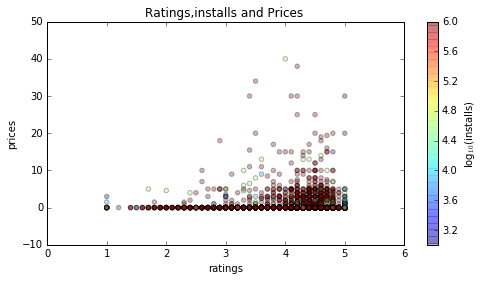

In [5]:
app1 = app[app['Price']<=40].dropna() # most apps are under 40 dollars, filter to make it easier to see the trend
plt.rcParams['figure.figsize'] = (8, 4)
ratings = app1['Rating']
prices = app1['Price'] 
ins = app1['Installs']
plt.scatter(ratings, prices, c= np.log(ins),alpha = 0.3,label = None) # installs is very large, so I log them
plt.xlabel('ratings')
plt.ylabel('prices')
plt.colorbar(label = 'log$_{10}$(installs)')
plt.clim(3,6)
plt.title('Ratings,installs and Prices ')
plt.show;

<br>&emsp;We can roughly conclude that as the rating increases, the number of installs does not necessarily increase. Prices are not effect much to rating ,but if the app is very expensive, it might get low ratings. 
<br>&emsp;Then PCA was performed to reduce dimension so we can better visualize them. In PCA I scaled the variables, then looked at the loadings of each principle component and drew a biplot. Since PCA was used for visualization, the number of components was supposed to be two. The result is as following:

In [6]:
df = app.groupby(['Category'])[['Rating', 'Installs', 'Price']].mean()

In [7]:
# scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df)
df_scaled=scaler.transform(df)

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) 
pca.fit(df_scaled)
pca_loadings = pca.components_

1


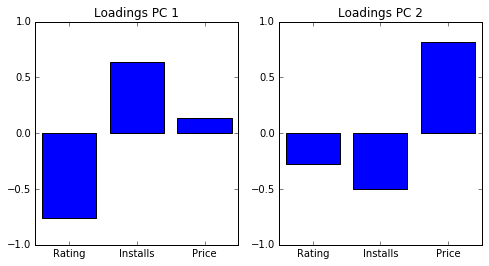

In [9]:
plt.figure()
for i in range(2):
    plt.subplot(1,2,i+1)
    heights = np.squeeze(pca_loadings[i,:])
    bars = ['Rating', 'Installs', 'Price']
    x_pos = np.arange(len(bars))
    plt.bar(x_pos, heights)
    plt.xticks(x_pos, bars)
    plt.title("Loadings PC "+str(i+1))
    plt.ylim(-1,1)
print(i);

The first loading vector places most weight on installs and ratings, with much less weight on Prices. The second loading vector places most of its weight on prices and much less weight on the other two features.

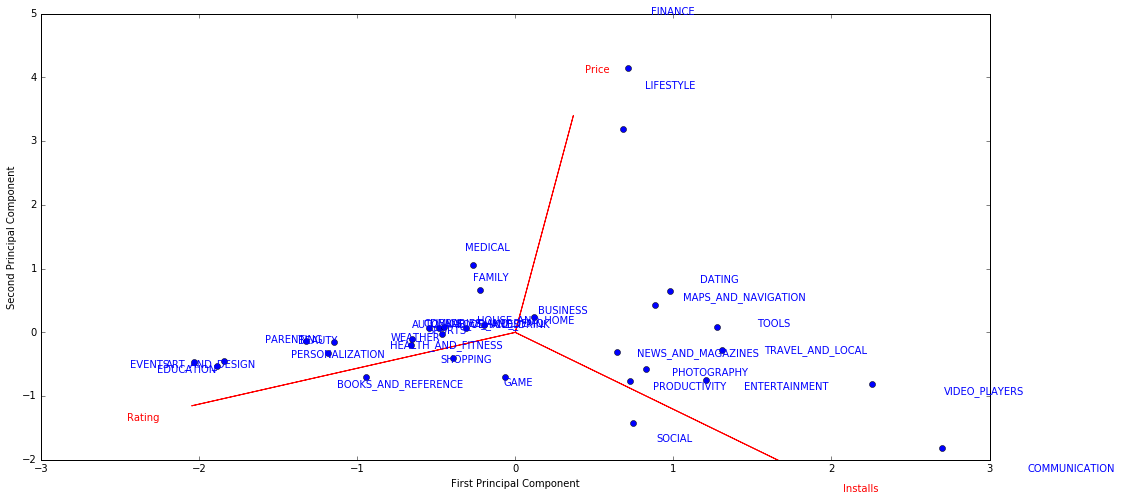

In [10]:
pca_scores = pca.fit_transform(df_scaled)
plt.rcParams['figure.figsize'] = (17, 8)
# Reference: https://github.com/teddyroland/python-biplot/blob/master/biplot.py
xvector = pca.components_[0] 
yvector = pca.components_[1]
xs = pca_scores[:,0]
ys = pca_scores[:,1]
for i in range(len(xvector)):
# arrows project features (ie columns from csv) as vectors onto PC axes
    plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
              color='r', width=0.0005, head_width=0.0025)
    plt.text(xvector[i]*max(xs)*1.2, yvector[i]*max(ys)*1.2,
             list(df.columns.values)[i], color='r')

for i in range(len(xs)):
# circles project documents (ie rows from csv) as points onto PC axes
    plt.plot(xs[i], ys[i], 'bo')
    plt.text(xs[i]*1.2, ys[i]*1.2, list(df.index)[i], color='b')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show();

<br>&emsp;The blue category names represent the scores for the first two principal components. The red arrows indicate the first two principal component loading vectors. All three PCAs are similarly correlated with the others. 
<br>&emsp;Categories with large positive scores on the first component, such as Communication, Video_players and Travel_and_local, have high installations, while categories like Education,Events and Art & Design, with negative scores on the first component, have high ratings. Categories close to zero on both components, such as Health & Fitness, have approximately average levels of both installs and ratings. Lifestyle and Finance categories have high positive scores on the second component, indicating that they have relatively high prices.
<br>&emsp;Therefore, developers can look at this biplot to evaluate overall performances of apps in different categories.

### Question 2

Q2: How do different variables influence the rating of apps? 

For this question, I drew figures to visualize the relationship between variables.

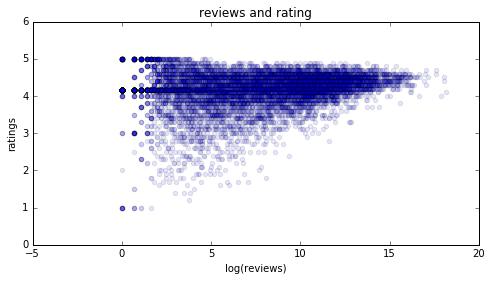

In [11]:
plt.rcParams['figure.figsize'] = (8, 4)
plt.scatter(x=np.log(app.Reviews), y=app.Rating,alpha=0.1)
plt.ylabel('ratings')
plt.xlabel('log(reviews)')
plt.title('reviews and rating');

It seems like well-known applications will get a good rating.

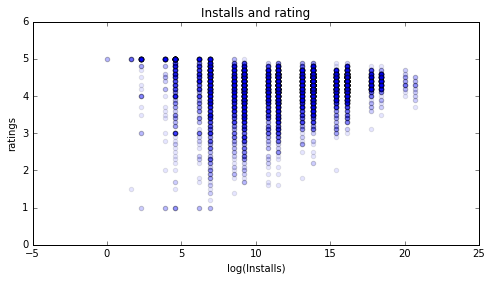

In [12]:
plt.rcParams['figure.figsize'] = (8, 4)
plt.scatter(x=np.log(app.Installs), y=app.Rating,alpha=0.1)
plt.ylabel('ratings')
plt.xlabel('log(Installs)')
plt.title('Installs and rating');

The number of installs will affect ratings but they are not a simple positive correlation. Generally, more installs indicate the app is relatively well-known and this confirms the value of the app, which will be reflected on rating. However, more users will also bring more negative feedback.

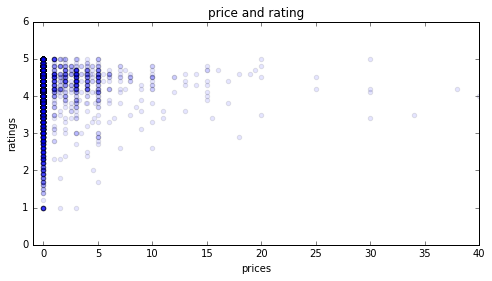

In [13]:
plt.rcParams['figure.figsize'] = (8, 4)
plt.scatter(x=app.Price, y=app.Rating,alpha=0.1)
plt.ylabel('ratings')
plt.xlabel('prices')
plt.xlim(-1,40)
plt.title('price and rating');

Higher price application may make customer disappointed, if they are not good enough. However, if they are good enough, they will have a good rating even with a price.

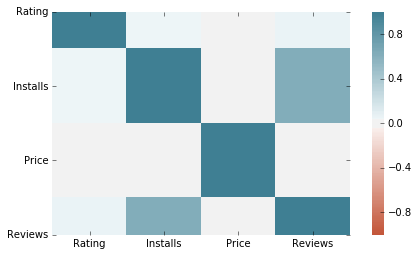

In [14]:
corr=app[['Rating','Installs','Price','Reviews']].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
);

From this heatmap, we can have an overall idea of the association among all these continuous variables. We can find that reviews and installs have a relatively stronger relationship among these variables. However, rating does not show a very strong relationship with others.

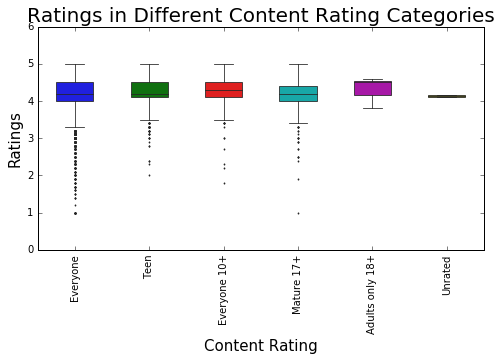

In [15]:
plt.rcParams['figure.figsize'] = (8, 4)
sns.boxplot(y = app['Rating'], x = app['Content Rating'],width=0.5, linewidth=0.8,fliersize=1)
plt.xticks(rotation=90)
plt.ylim(0,6)
plt.title('Ratings in Different Content Rating Categories',fontsize = 20)
plt.ylabel('Ratings',fontsize = 15)
plt.xlabel('Content Rating',fontsize = 15)
plt.show();

Content Rating does not effect too much to rating, but in Mature applications, it looks like they get a lower median rating than others.

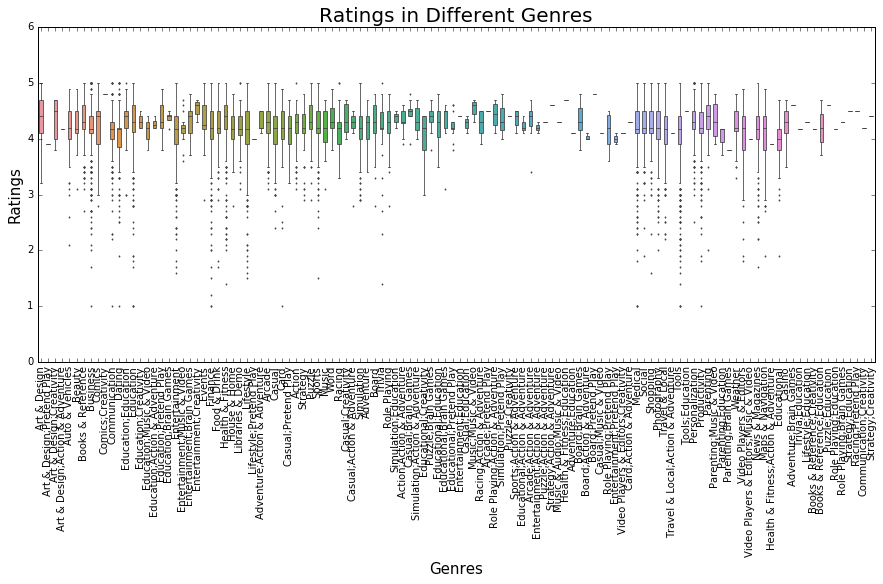

In [16]:
plt.rcParams['figure.figsize'] = (15, 6)
sns.boxplot(y = app['Rating'], x = app['Genres'],width=0.5, linewidth=0.8,fliersize=1)
plt.xticks(rotation=90)
plt.ylim(0,6)
plt.title('Ratings in Different Genres',fontsize = 20)
plt.ylabel('Ratings',fontsize = 15)
plt.xlabel('Genres',fontsize = 15)
plt.show();

Genres like Art & Design have a relatively higher rating.

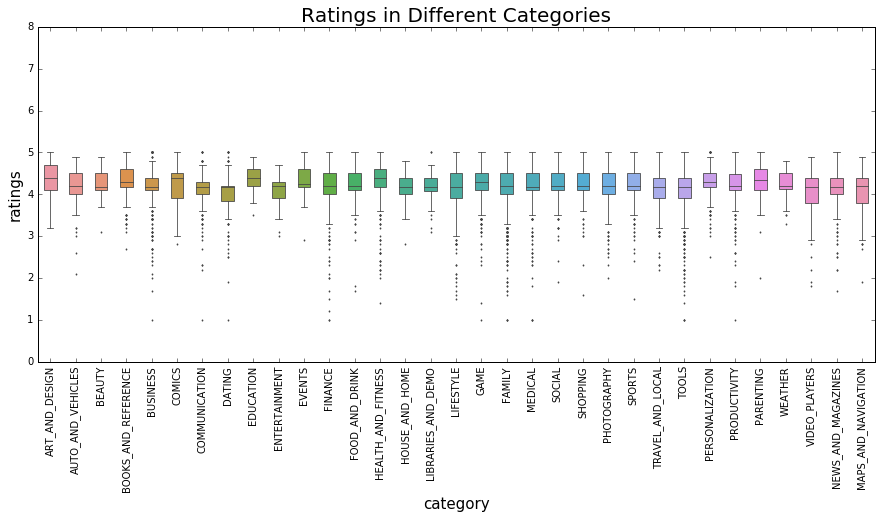

In [17]:
plt.rcParams['figure.figsize'] = (15, 6)
sns.boxplot(y = app['Rating'], x = app['Category'],width=0.5, linewidth=0.8,fliersize=1)
plt.xticks(rotation=90)
plt.ylim(0,8)
plt.title('Ratings in Different Categories',fontsize = 20)
plt.ylabel('ratings',fontsize = 15)
plt.xlabel('category',fontsize = 15)
plt.show();

There are not very obvious differences in ratings between different categories.It seems that Dating apps have a relative lower rating.

From all above results, we find that in order to make a high rating app, we had better make it free if we are not so confident in its appealing. Making policies to attract more users and inspire old users to write a review might help improve rating. Generally speaking, rating is influenced by many factors. To be specific, apps whose content rating is adults over 18+ and genre in Art & Design might be a good start.

### Question 3

Q3: How to cluster apps into specific number of clusters?

In [18]:
combine = pd.merge(app,review,on='App',how='left')

I merged external dataset with original dataset and I calculated the proportion of neutral, positive and negative reviews, as well as the mean value of sentiment polarity and subjectivity for each app.The original merged dataset is:

In [19]:
combine.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159.0,19M,10000.0,Free,0.0,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3 and up,NaN,NaN,NaN,NaN
1,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14M,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up,A kid's excessive ads. The types ads allowed a...,Negative,-0.250,1.000000
2,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14M,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up,It bad >:(,Negative,-0.725,0.833333
3,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14M,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up,like,Neutral,0.000,0.000000
4,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14M,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up,I love colors inspyering,Positive,0.500,0.600000


The dataset ready for analysis is as follows:

In [20]:
#calculate the proportion of neutral,positive,negative reviews
sentiment_count = combine.groupby(['App','Sentiment']).count()
proportion = sentiment_count['Category']
proportion = proportion.groupby(level=0).apply(lambda x:
                             x / float(x.sum()))

In [21]:
p = proportion.to_frame()
p = p.reset_index(level=['App', 'Sentiment']) 
# select neutral,positive,negative reviews separately
propor_po = p[p['Sentiment'].isin(['Positive'])][['App','Category']]
propor_ne = p[p['Sentiment'].isin(['Negative'])][['App','Category']]
propor_neu = p[p['Sentiment'].isin(['Neutral'])][['App','Category']]
# change column names
propor_po.columns = ['App', 'positive_proportion']
propor_ne.columns = ['App','negative_proportion']
propor_neu.columns = ['App','neutral_proportion']
# calculate average sentiment polarity and subjectivity
sentiment_polar = pd.DataFrame(combine.dropna().groupby(['App'])['Sentiment_Polarity'].mean()).reset_index()
sentiment_sub = pd.DataFrame(combine.dropna().groupby(['App'])['Sentiment_Subjectivity'].mean()).reset_index()
# merge all these data frames at the same time
from functools import reduce
data_frames = [app,propor_po, propor_ne, propor_neu,sentiment_polar,sentiment_sub]
sentiment3 = reduce(lambda  left,right: pd.merge(left,right,on=['App'],
                                            how='outer'), data_frames)
sentiment3.head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,positive_proportion,negative_proportion,neutral_proportion,Sentiment_Polarity,Sentiment_Subjectivity
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159.0,19M,10000.0,Free,0.0,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3 and up,NaN,NaN,NaN,NaN,NaN
1,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14M,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up,0.590909,0.318182,0.090909,0.152652,0.64154
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510.0,8.7M,5000000.0,Free,0.0,Everyone,Art & Design,2018-08-01,1.2.4,4.0.3 and up,NaN,NaN,NaN,NaN,NaN


Considering the inner correlation within review-related variables, I performed PCA on all the continuous variables. First let's look at their inner correlation after removing missing values:

In [22]:
features = ['Rating','Reviews','Installs','Price','positive_proportion','negative_proportion','neutral_proportion','Sentiment_Polarity','Sentiment_Subjectivity']
# Separating out the features
x = sentiment3[features].dropna()
corr = x.corr()
corr

,Rating,Reviews,Installs,Price,positive_proportion,negative_proportion,neutral_proportion,Sentiment_Polarity,Sentiment_Subjectivity
Rating,1.000000,0.056083,0.054036,0.001607,0.431276,-0.301572,-0.248799,0.373633,0.262494
Reviews,0.056083,1.000000,0.593227,-0.012770,-0.092115,0.157870,-0.060945,-0.114292,-0.016937
Installs,0.054036,0.593227,1.000000,-0.017040,-0.045206,0.111939,-0.071980,-0.090370,-0.015241
Price,0.001607,-0.012770,-0.017040,1.000000,0.056094,-0.052674,-0.015941,0.056074,-0.001360
positive_proportion,0.431276,-0.092115,-0.045206,0.056094,1.000000,-0.726265,-0.543919,0.783831,0.573728
negative_proportion,-0.301572,0.157870,0.111939,-0.052674,-0.726265,1.000000,-0.181807,-0.861837,-0.140730
neutral_proportion,-0.248799,-0.060945,-0.071980,-0.015941,-0.543919,-0.181807,1.000000,-0.069198,-0.648915
Sentiment_Polarity,0.373633,-0.114292,-0.090370,0.056074,0.783831,-0.861837,-0.069198,1.000000,0.391365
Sentiment_Subjectivity,0.262494,-0.016937,-0.015241,-0.001360,0.573728,-0.140730,-0.648915,0.391365,1.000000


For every cell, row variable correlation with the column variable is the value of the cell. Higher absolute values indicate stronger relationship.

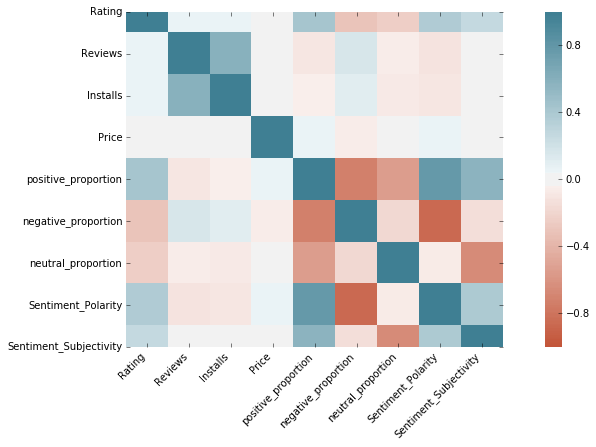

In [23]:
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

From the heatmap, we can see that reviews and installs, sentiment_polarity and positive_proportion,sentiment_polarity and negative_proportion, as well as negative_proportion and positive_proportion have a stronger inner relationship among themselves.

<br>&emsp;Then I scaled these variables and determined k number.

In [24]:
scaler = StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)
pca = PCA() 
pca.fit(x_scaled)
print('The variance explained by the components is \n' + str(pca.explained_variance_ratio_))

The variance explained by the components is 
[3.56406293e-01 1.98247367e-01 1.55489477e-01 1.10871684e-01
 8.15403140e-02 4.56614431e-02 3.90249155e-02 1.27585066e-02
 1.27313702e-32]


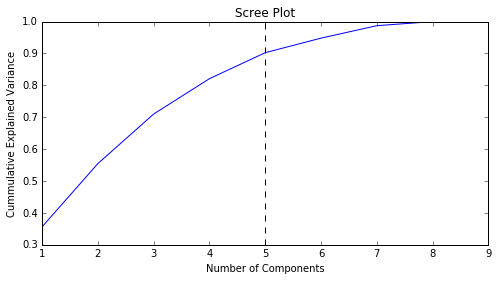

In [25]:
plt.rcParams['figure.figsize'] = (8, 4)
plt.plot(np.arange(1,10) , np.cumsum(pca.explained_variance_ratio_))
plt.axvline(5,color='black', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cummulative Explained Variance')
plt.title('Scree Plot')
plt.show();

From the scree plot I decided to keep 5 components in order to explain approximately 90% variance.

Let us look at the first two PCAs' loadings and then get PCA scores.

1


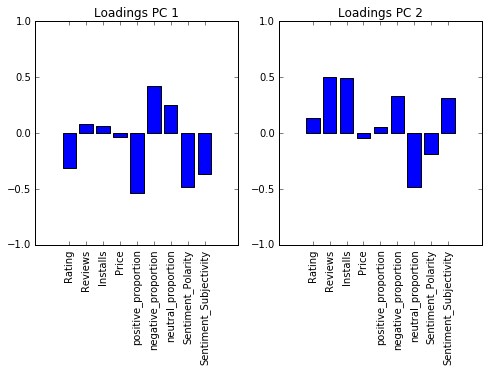

In [26]:
pca = PCA(n_components=5)
pca.fit(x_scaled)
pca_loadings = pca.components_
plt.rcParams['figure.figsize'] = (8, 4)
plt.figure()
for i in range(2):
    plt.subplot(1,2,i+1)
    heights = np.squeeze(pca_loadings[i,:])
    bars = ['Rating','Reviews','Installs','Price','positive_proportion','negative_proportion','neutral_proportion','Sentiment_Polarity','Sentiment_Subjectivity']
    x_pos = np.arange(len(bars))
    plt.bar(x_pos, heights)
    plt.xticks(x_pos, bars,rotation=90)
    plt.title("Loadings PC "+str(i+1))
    plt.ylim(-1,1)
print(i)

The first loading vector places most weight on review-related variables, with much less weight on others. The second loading vector places most of its weight on prices, rating and installs.

Then I considered these variables together with content rating and category at the same time since content rating and category are definitely evidence of cluster. Considering we have both continuous and categorical variables at the same time, I used k-prototypes clustering. I clustered all apps into 10 clusters as follows:

In [27]:
from kmodes.kprototypes import KPrototypes
pca_scores = pca.fit_transform(x_scaled)
sentiment3[['PCA1','PCA2','PCA3','PCA4','PCA5']] = pd.DataFrame(pca_scores[:,0:5])
cluster_df = sentiment3[['PCA1','PCA2','PCA3','PCA4','PCA5','Category','Content Rating']].dropna()
kproto = KPrototypes(n_clusters=10, init='Cao')
clusters = kproto.fit_predict(cluster_df, categorical=[5, 6])
cluster_df['kmodes'] = clusters

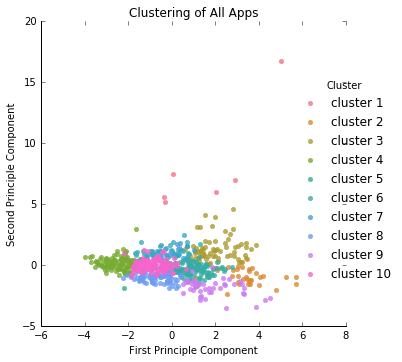

In [28]:
g = sns.lmplot("PCA1", "PCA2", data=cluster_df,  
           hue='kmodes', fit_reg=False)
g.set(xlabel = 'First Principle Component',ylabel='Second Principle Component',title='Clustering of All Apps')
g._legend.set_title('Cluster')
new_labels = ['cluster 1', 'cluster 2','cluster 3','cluster 4','cluster 5','cluster 6','cluster 7','cluster 8','cluster 9','cluster 10']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l);

We can have a rough look at some of the apps and the cluster it belongs to. 

In [29]:
syms = sentiment3[['App','PCA1','PCA2','PCA3','PCA4','PCA5','Category','Content Rating']].dropna().App
for s, c in zip(syms[5:15], clusters[5:15]):
    print("App: {}, cluster:{}".format(s, c))

App: Paper flowers instructions, cluster:3
App: Smoke Effect Photo Maker - Smoke Editor, cluster:5
App: Infinite Painter, cluster:7
App: Garden Coloring Book, cluster:3
App: Kids Paint Free - Drawing Fun, cluster:3
App: Text on Photo - Fonteee, cluster:7
App: Name Art Photo Editor - Focus n Filters, cluster:3
App: Tattoo Name On My Photo Editor, cluster:5
App: Mandala Coloring Book, cluster:7
App: 3D Color Pixel by Number - Sandbox Art Coloring, cluster:3


For example,in cluster 3, App Paper flowers instructions, Garden Coloring Book, and Name Art Photo Editor all belongs to ART_AND_DESIGN category and they all have a relatively high rating or installs. Whereas other apps like smoke Effect Photo Maker and Text on Photo, they are also in ART_AND_DESIGN category but they have a relatively lower rating and installs, so they are clustered into other groups. Therefore, when we analyze apps we are interested in, we can ignore apps in the same category but in the different cluster, since they perform relatively worse and do not have much value for analysis.

In summary so far we cluster all apps into 10 clusters and we can get the cluster each app belongs to. In each cluster, the apps belongs to similar categories and have similar content rating, also, they perform similarly in installs, ratings and so on.Therefore when we determine to develop apps in a certain category, we can further explore similar apps in the same cluster to learn more about their pattern of success.

## <center> Conclusion</center>

<br>&emsp;In summary, regarding performances in different categories, app in Communication, Video_players and Travel_and_local have high installations, while categories like Education,Events and Art & Design have high ratings. Categories such as Health & Fitness, have approximately average levels of both installs and ratings. Lifestyle and Finance categories have relatively higher prices. In order to make a high rating app, we had better make it free if we are not so confident about its performance. Inspiration for installation and writing a review is also a good strategy. We can cluster all different apps into 10 clusters and in each cluster, the apps have similar content or category, and perform similarly in rating, install and reviews.

## <center> Appendix</center>

### EDA

#### Data Collection

In this part, I collect data and look at its content, shape and data types.

app dataset:

In [30]:
app = pd.read_csv('googleplaystore.csv')
review = pd.read_csv('googleplaystore_user_reviews.csv')
app.head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up


In [31]:
print ("The shape of the app dataset is " + str(app.shape))

The shape of the app dataset is (10841, 13)


In [32]:
print ("The data type of the app dataset is:\n" + str(app.dtypes))

The data type of the app dataset is:
App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object


review dataset:

In [33]:
review.head(3)

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN


In [34]:
print ("The shape of the review dataset is " + str(review.shape))

The shape of the review dataset is (64295, 5)


In [35]:
print ("The data type of the review dataset is:\n" + str(review.dtypes))

The data type of the review dataset is:
App                        object
Translated_Review          object
Sentiment                  object
Sentiment_Polarity        float64
Sentiment_Subjectivity    float64
dtype: object


The types of 'price','Reviews' and 'Last Updated' in app dataset deserve attention.

#### Data Cleaning

In this part, I cleaned the data by changing wrong data types, removing errors and duplicate records,as well as dealing with missing values.

(1) Duplicate records:

In [36]:
print ("The unique number of observations of apps in app dataset is:" + str(app.App.nunique()))

The unique number of observations of apps in app dataset is:9660


This means there are duplicate records for the same app.
Remove duplicate apps and keep the first record:

In [37]:
app = app.drop_duplicates(subset=['App'], keep='first')

(2) Cope with errors and change data type in each variable volumn in app dataset
<br> Prices:
<br>1. Remove dollar sign  e.g. change $0.99 to 0.99
<br>2. There are wrong values like 'Everyone', not a price
<br>3. Change data type to float

In [38]:
app = app[(app.Price != 'Everyone' )]
app.Price = app.dropna().Price.apply(lambda x: x.replace('$',''))
app['Price'] = app['Price'].astype(float)

Date:
<br> Change data type to datatime

In [39]:
app['Last Updated'] = pd.to_datetime(app['Last Updated'] )

Installs:
<br>1. Remove '+' and ','  e.g. change 1,000+ to 1000
<br>2. Change data type to int.

In [40]:
app.Installs = app.dropna().Installs.apply(lambda x: x.replace('+','').replace(',',''))
app['Installs'] = app['Installs'].dropna().astype(int)

Reviews:
<br> change data type to float

In [41]:
app['Reviews'] = app['Reviews'].astype(float)

<br> (3) Missing values
<br> Missing values in the app dataset:

In [42]:
app.isna().sum()

App                  0
Category             0
Rating            1463
Reviews              0
Size                 0
Installs          1469
Type                 1
Price             1469
Content Rating       0
Genres               0
Last Updated         0
Current Ver          8
Android Ver          2
dtype: int64

I fill the missing value in column Rating with mean rating value, just leave NaN for columns Installs and Type. For column Price, if Type equals Free, then it should be zero.If the app requires payment,considering the huge differences between prices, I just leave NaN for that price.

In [43]:
app.loc[app.Type == 'Free', 'Price'] = 0
app.Rating = app.Rating.fillna(app.Rating.mean())

Missing values in the review dataset:

In [44]:
review.isna().sum()

App                           0
Translated_Review         26868
Sentiment                 26863
Sentiment_Polarity        26863
Sentiment_Subjectivity    26863
dtype: int64

I drop all rows with missing values in review dataset.

In [45]:
review = review.dropna(axis = 'rows') 

Have a look at the finally cleaned app dataset.

In [46]:
app.head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159.0,19M,10000.0,Free,0.0,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14M,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510.0,8.7M,5000000.0,Free,0.0,Everyone,Art & Design,2018-08-01,1.2.4,4.0.3 and up


#### Data Visualisation and Exploration

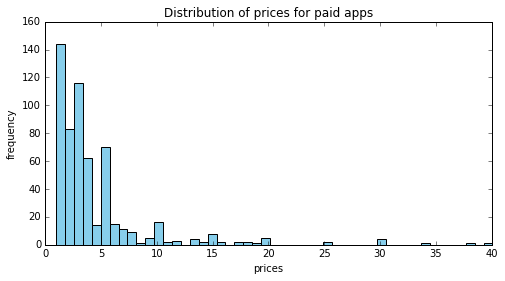

In [47]:
paid = app[app['Type'].isin(['Paid'])] 
plt.rcParams['figure.figsize'] = (8, 4)
plt.hist(paid.Price,bins=500,color = "skyblue")
plt.xlim(0,40) # remove outliers
plt.xlabel('prices')
plt.ylabel('frequency')
plt.title('Distribution of prices for paid apps')
plt.show();

Most apps have a low price.

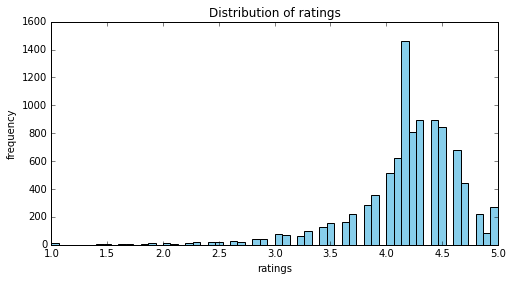

In [48]:
plt.rcParams['figure.figsize'] = (8, 4)
rat = app.Rating
plt.hist(rat,bins=60,color = "skyblue")
plt.xlabel('ratings')
plt.ylabel('frequency')
plt.title('Distribution of ratings')
plt.show();

For most apps, the ratings are around 4.3 to 4.7.

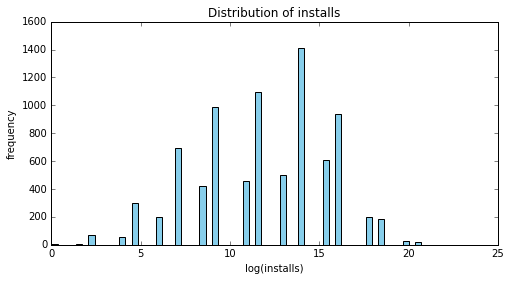

In [49]:
plt.rcParams['figure.figsize'] = (8, 4)
rat = np.log(app.Installs)
plt.hist(rat,bins=60,color = "skyblue")
plt.xlabel('log(installs)')
plt.ylabel('frequency')
plt.title('Distribution of installs')
plt.show();

Most popular apps have around 20k installs.

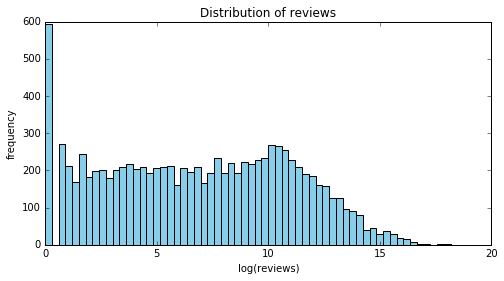

In [50]:
plt.rcParams['figure.figsize'] = (8, 4)
rew = app.Reviews.dropna()
plt.hist(np.log(rew+1),bins=60,color = "skyblue")
plt.xlabel('log(reviews)')
plt.ylabel('frequency')
plt.title('Distribution of reviews')
plt.show();

Not so many apps have over 20k reviews.

There are many categories, let's look at them.

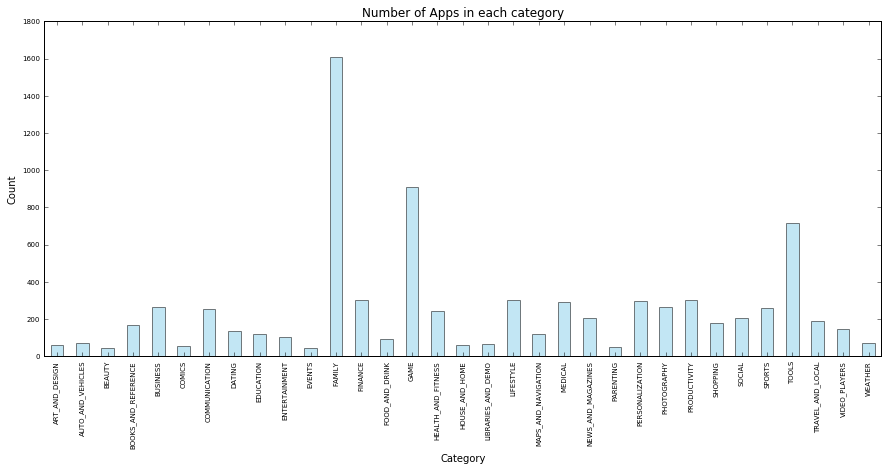

In [51]:
plt.rcParams['figure.figsize'] = (15, 6)
count_category = app.dropna().groupby(['Category']).count() 
count_category.App.plot(kind='bar', fontsize = 7, rot=0,title="Number of Apps in each category",color = "skyblue",alpha=0.5)
plt.ylabel('Count')
plt.xlabel('Category')
plt.xticks(rotation=90); # prevent x axis overlap

The top three categories that have most apps are Family,Game and Tools.

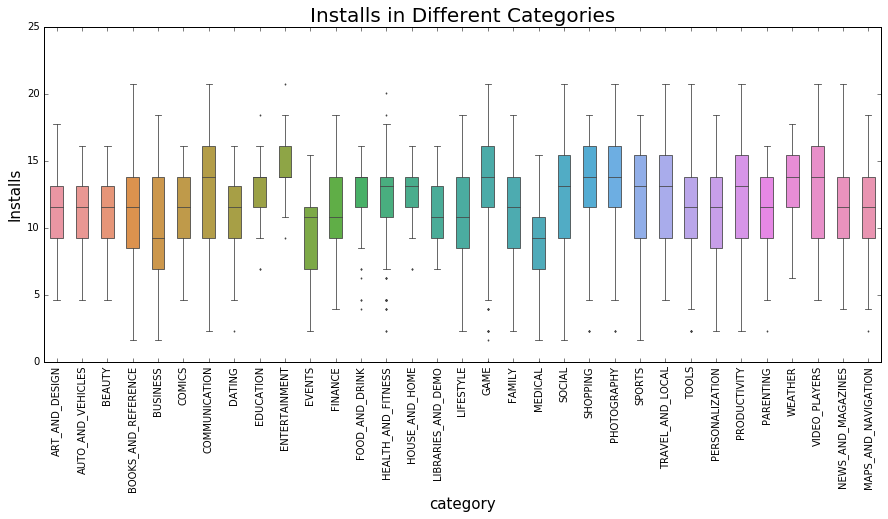

In [52]:
plt.rcParams['figure.figsize'] = (15, 6)
sns.boxplot(y = np.log(app['Installs']), x = app['Category'],width=0.5, linewidth=0.8,fliersize=1)
plt.xticks(rotation=90)
#plt.ylim(0,8)
plt.title('Installs in Different Categories',fontsize = 20)
plt.ylabel('Installs',fontsize = 15)
plt.xlabel('category',fontsize = 15)
plt.show();

Entertainment apps have many more installs while business and medical apps have fewer installs.This makes sense since everyone needs entertainment while business and medical apps are more open to people in business or caring more about health.

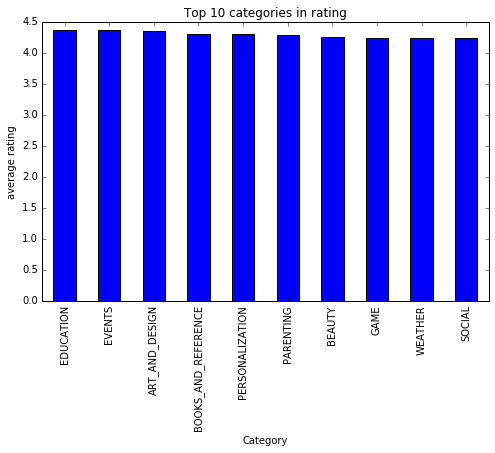

In [53]:
plt.rcParams['figure.figsize'] = (8, 5)
app.groupby(['Category'])['Rating'].mean().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 categories in rating')
plt.ylabel('average rating');

All these top rating categories are similar in rating.It makes sense since education, beauty,social and game are all major parts of our daily life.

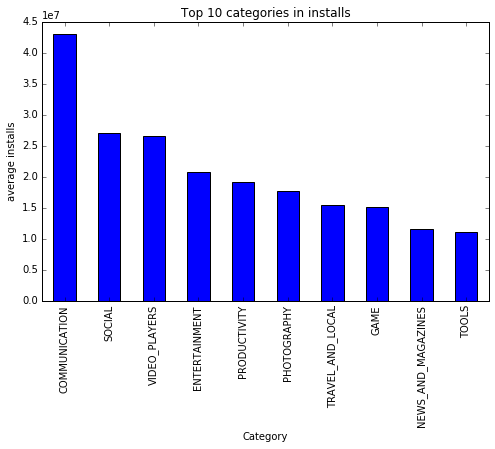

In [54]:
plt.rcParams['figure.figsize'] = (8, 5)
app.groupby(['Category'])['Installs'].mean().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 categories in installs')
plt.ylabel('average installs');

Some categories do a good job both in installs and ratings like social and game.The most popular apps are about communication, social and video players.

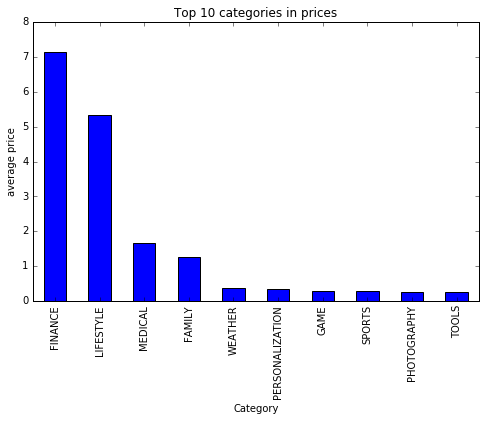

In [55]:
plt.rcParams['figure.figsize'] = (8, 5)
app.groupby(['Category'])['Price'].mean().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 categories in prices')
plt.ylabel('average price');

It makes sense that finance apps are expensive.

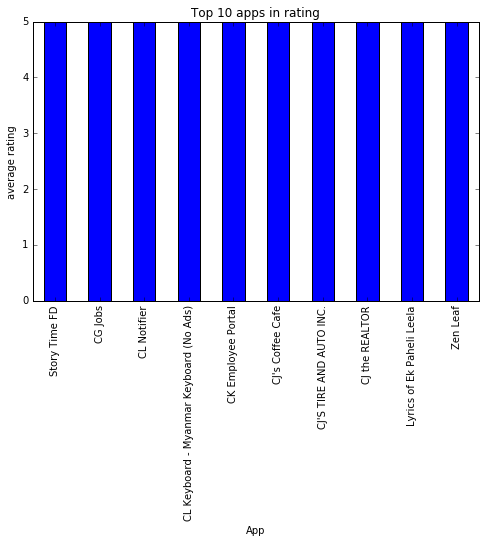

In [56]:
plt.rcParams['figure.figsize'] = (8, 5)
app.groupby(['App'])['Rating'].mean().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 apps in rating')
plt.ylabel('average rating');

These apps are not so popular, it is possible that they have a high rating only due to few users placing ratings.

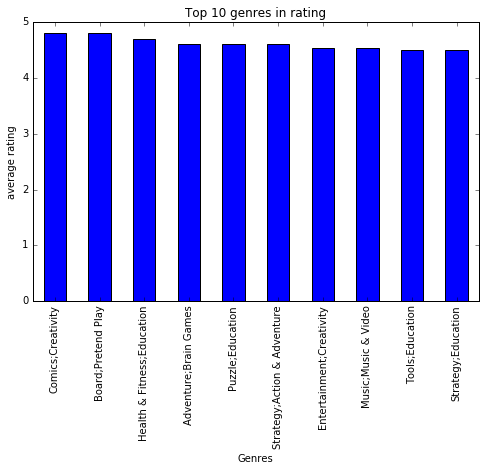

In [57]:
plt.rcParams['figure.figsize'] = (8, 5)
app.groupby(['Genres'])['Rating'].mean().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 genres in rating')
plt.ylabel('average rating');

Creativity, pretend play and health, fitness and education apps rank higher in rating.

### References

[1] Google Play Store Apps, Web scraped data of 10k Play Store apps for analysing the Android market.     <br>&emsp;https://www.kaggle.com/lava18/google-play-store-apps

[2] Python implementations of the k-modes and k-prototypes clustering algorithms, for clustering categorical data.
<br>&emsp;https://github.com/nicodv/kmodes

[3] Huang, Z.: Clustering large data sets with mixed numeric and categorical values, Proceedings of the First Pacific Asia <br>&emsp;Knowledge Discovery and Data Mining Conference, Singapore, pp. 21-34, 1997.

[4] Z.Huang (1998): Extensions to the k-Means Algorithm for Clustering Large Data Sets with Categorical Variables, Data Mining <br>&emsp;and Knowledge Discovery 2, 283-304.